In [ ]:
import tensorflow as tf
import numpy as np

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)

    def get_angles(self, position, i, hidden_dim):
        angles = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(hidden_dim, tf.float32))
        return position * angles

    def get_positional_encoding(self, timesteps, hidden_dim):
        angle_rads = self.get_angles(
            position=tf.range(timesteps, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(hidden_dim, dtype=tf.float32)[tf.newaxis, :],
            hidden_dim=hidden_dim
        )
        # apply sin to even index in the array
        sines = tf.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        timesteps = tf.shape(inputs)[1]
        hidden_dim = tf.shape(inputs)[2]
        pos_encoding = self.get_positional_encoding(timesteps, hidden_dim)
        return inputs + pos_encoding

    def compute_output_shape(self, input_shape):
        return input_shape

def transformer_block(hidden_dim, num_heads, ff_dim, dropout_rate):
    inputs = tf.keras.layers.Input(shape=(None, hidden_dim))
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)(inputs, inputs)
    attention_output = tf.keras.layers.Dropout(dropout_rate)(attention_output)
    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(attention_output)
    ff_output = tf.keras.layers.Dense(hidden_dim)(ff_output)
    ff_output = tf.keras.layers.Dropout(dropout_rate)(ff_output)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + ff_output)

    return tf.keras.models.Model(inputs, outputs)

def encoder_embedder(timesteps, features, hidden_dim, num_layers):
    '''
    Encoder embedder, takes as input the actual sequences and returns the actual embeddings.
    '''
    x = tf.keras.layers.Input(shape=(timesteps, features))
    e = tf.keras.layers.Dense(hidden_dim)(x)
    e = PositionalEncoding()(e)
    for _ in range(num_layers):
        e = transformer_block(hidden_dim=hidden_dim, num_heads=4, ff_dim=hidden_dim * 4, dropout_rate=0.1)(e)
    return tf.keras.models.Model(x, e, name='encoder_embedder')

def generator_embedder(timesteps, features, hidden_dim, num_layers):
    z = tf.keras.layers.Input(shape=(timesteps, features))
    x = PositionalEncoding()(z)  # Add positional encoding before feeding into the Transformer
    for _ in range(num_layers):
        e = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=hidden_dim)(x if _ == 0 else e, x if _ == 0 else e)
        e = tf.keras.layers.LayerNormalization()(e)
        e = tf.keras.layers.Dense(units=hidden_dim, activation='relu')(e)
    return tf.keras.models.Model(z, e, name='generator_embedder')

def encoder(timesteps, hidden_dim, num_layers):
    '''
    Encoder, takes as input the actual embeddings and returns the actual latent vector.
    '''
    e = tf.keras.layers.Input(shape=(timesteps, hidden_dim))
    h = e
    for _ in range(num_layers):
        h = transformer_block(hidden_dim=hidden_dim, num_heads=4, ff_dim=hidden_dim * 4, dropout_rate=0.1)(h)
    h = tf.keras.layers.Dense(units=hidden_dim)(h)
    return tf.keras.models.Model(e, h, name='encoder')

def generator(timesteps, hidden_dim, num_layers):
    '''
    Generator, takes as input the synthetic embeddings and returns the synthetic latent vector.
    '''
    e = tf.keras.layers.Input(shape=(timesteps, hidden_dim))
    h = e
    for _ in range(num_layers):
        h = transformer_block(hidden_dim=hidden_dim, num_heads=4, ff_dim=hidden_dim * 4, dropout_rate=0.1)(h)
    h = tf.keras.layers.Dense(units=hidden_dim)(h)
    return tf.keras.models.Model(e, h, name='generator')

def decoder(timesteps, features, hidden_dim, num_layers):
    '''
    Decoder, takes as input the actual or synthetic latent vector and returns the reconstructed or synthetic sequences.
    '''
    h = tf.keras.layers.Input(shape=(timesteps, hidden_dim))
    for _ in range(num_layers):
        y = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=hidden_dim, activation='relu'))(h if _ == 0 else y)
    y = tf.keras.layers.Dense(units=features)(y)
    return tf.keras.models.Model(h, y, name='decoder')

def discriminator(timesteps, hidden_dim, num_layers):
    '''
    Discriminator, takes as input the actual or synthetic embedding or latent vector and returns the log-odds.
    '''
    h = tf.keras.layers.Input(shape=(timesteps, hidden_dim))
    for _ in range(num_layers):
        p = transformer_block(hidden_dim=hidden_dim, num_heads=4, ff_dim=hidden_dim * 4, dropout_rate=0.1)(h if _ == 0 else p)
    p = tf.keras.layers.Dense(units=1)(p)
    return tf.keras.models.Model(h, p, name='discriminator')

def simulator(samples, timesteps, features):
    '''
    Simulator, generates synthetic sequences from a Wiener process.
    '''
    z = tf.random.normal(mean=0, stddev=1, shape=(samples * timesteps, features), dtype=tf.float32)
    z = tf.cumsum(z, axis=0) / tf.sqrt(tf.cast(samples * timesteps, dtype=tf.float32))
    z = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    z = tf.reshape(z, (samples, timesteps, features))
    return z


@tf.function
def mean_squared_error(y_true, y_pred):
    '''
    Mean squared error, used for calculating the supervised loss and the reconstruction loss.
    '''
    loss = tf.keras.losses.MSE(y_true=tf.expand_dims(y_true, axis=-1), y_pred=tf.expand_dims(y_pred, axis=-1))
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))


@tf.function
def binary_crossentropy(y_true, y_pred):
    '''
    Binary cross-entropy, used for calculating the unsupervised loss.
    '''
    loss = tf.keras.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)
    return tf.reduce_mean(loss)

import numpy as np

def time_series_to_sequences(time_series, timesteps):
    '''
    Reshape the time series as sequences.
    '''
    sequences = np.array([time_series[t - timesteps: t] for t in range(timesteps, len(time_series) + timesteps, timesteps)])
    return sequences


def sequences_to_time_series(sequences):
    '''
    Reshape the sequences as time series.
    '''
    time_series = np.concatenate([sequence for sequence in sequences], axis=0)
    return time_series



In [ ]:
import numpy as np
import tensorflow as tf

class TimeGAN():
    def __init__(self,
                 x,
                 timesteps,
                 hidden_dim,
                 num_layers,
                 lambda_param,
                 eta_param,
                 learning_rate,
                 batch_size):
        '''
        Implementation of synthetic time series generation model introduced in Yoon, J., Jarrett, D. and Van der Schaar, M., 2019.
        Time-series generative adversarial networks. Advances in neural information processing systems, 32.
        '''

        # extract the length of the time series
        samples = x.shape[0]

        # extract the number of time series
        features = x.shape[2]
        print('features shape',features)

        # scale the time series
        mu = np.mean(x, axis=0)
        sigma = np.std(x, axis=0)
        x = (x - mu) / sigma

        # reshape the time series as sequences
        #x = time_series_to_sequences(time_series=x, timesteps=timesteps)
        print('shape', x.shape)
        # create the dataset
        dataset = tf.data.Dataset.from_tensor_slices(x)
        dataset = dataset.cache().shuffle(samples).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        # build the models
        autoencoder_model = tf.keras.models.Sequential([
            encoder_embedder(timesteps=timesteps, features=features, hidden_dim=hidden_dim, num_layers=1),
            encoder(timesteps=timesteps, hidden_dim=hidden_dim, num_layers=num_layers - 1),
            decoder(timesteps=timesteps, features=features, hidden_dim=hidden_dim, num_layers=num_layers)
        ])

        generator_model = tf.keras.models.Sequential([
            generator_embedder(timesteps=timesteps, features=features, hidden_dim=hidden_dim, num_layers=1),
            generator(timesteps=timesteps, hidden_dim=hidden_dim, num_layers=num_layers - 1),
        ])

        discriminator_model = discriminator(timesteps=timesteps, hidden_dim=hidden_dim, num_layers=num_layers)

        # instantiate the optimizers
        autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        # save the objects
        self.mu = mu
        self.sigma = sigma
        self.samples = samples
        self.timesteps = timesteps
        self.features = features
        self.lambda_param = lambda_param
        self.eta_param = eta_param
        self.dataset = dataset
        self.autoencoder_model = autoencoder_model
        self.generator_model = generator_model
        self.discriminator_model = discriminator_model
        self.autoencoder_optimizer = autoencoder_optimizer
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    def fit(self, epochs, verbose=True):
        '''
        Train the model.
        '''

        # define the training loop
        @tf.function
        def train_step(data):
            with tf.GradientTape() as autoencoder_tape, tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
                print('SHAAAPE',data.shape)
                # get the actual sequences
                x = tf.cast(data, dtype=tf.float32)

                # generate the synthetic sequences
                z = simulator(samples=x.shape[0], timesteps=self.timesteps, features=self.features)

                # get the encoder outputs
                ex = self.autoencoder_model.get_layer('encoder_embedder')(x)     # actual embedding
                hx = self.autoencoder_model.get_layer('encoder')(ex)             # actual latent vector

                # get the generator outputs
                ez = self.generator_model.get_layer('generator_embedder')(z)     # synthetic embedding
                hz = self.generator_model.get_layer('generator')(ez)             # synthetic latent vector
                hx_hat = self.generator_model.get_layer('generator')(ex)         # conditional synthetic latent vector (i.e. given the actual embedding)

                # get the decoder outputs
                x_hat = self.autoencoder_model.get_layer('decoder')(hx)          # reconstructed sequences

                # get the discriminator outputs
                p_ex = self.discriminator_model(ex)                              # log-odds of actual embedding
                p_ez = self.discriminator_model(ez)                              # log-odds of synthetic embedding
                p_hx = self.discriminator_model(hx)                              # log-odds of actual latent vector
                p_hz = self.discriminator_model(hz)                              # log-odds of synthetic latent vector

                # calculate the supervised loss
                supervised_loss = mean_squared_error(hx[:, 1:, :], hx_hat[:, :-1, :])

                # calculate the autoencoder loss
                autoencoder_loss = mean_squared_error(x, x_hat) + \
                                   self.lambda_param * supervised_loss

                # calculate the generator loss
                generator_loss = binary_crossentropy(tf.ones_like(p_hz), p_hz) + \
                                 binary_crossentropy(tf.ones_like(p_ez), p_ez) + \
                                 self.eta_param * supervised_loss

                # calculate the discriminator loss
                discriminator_loss = binary_crossentropy(tf.zeros_like(p_hz), p_hz) + \
                                     binary_crossentropy(tf.zeros_like(p_ez), p_ez) + \
                                     binary_crossentropy(tf.ones_like(p_hx), p_hx) + \
                                     binary_crossentropy(tf.ones_like(p_ex), p_ex)

            # calculate the gradients
            autoencoder_gradient = autoencoder_tape.gradient(autoencoder_loss, self.autoencoder_model.trainable_variables)
            generator_gradient = generator_tape.gradient(generator_loss, self.generator_model.trainable_variables)
            discriminator_gradient = discriminator_tape.gradient(discriminator_loss, self.discriminator_model.trainable_variables)

            # update the weights
            self.autoencoder_optimizer.apply_gradients(zip(autoencoder_gradient, self.autoencoder_model.trainable_variables))
            self.generator_optimizer.apply_gradients(zip(generator_gradient, self.generator_model.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_gradient, self.discriminator_model.trainable_variables))

            return autoencoder_loss, generator_loss, discriminator_loss

        # train the model
        for epoch in range(epochs):
            for data in self.dataset:
                autoencoder_loss, generator_loss, discriminator_loss = train_step(data)
            if verbose:
                print(
                    f'epoch: {1 + epoch} '
                    f'autoencoder_loss: {format(autoencoder_loss.numpy(), ".6f")} '
                    f'generator_loss: {format(generator_loss.numpy(), ".6f")} '
                    f'discriminator_loss: {format(discriminator_loss.numpy(), ".6f")}'
                )

    def reconstruct(self, x):
        '''
        Reconstruct the time series.
        '''

        # scale the time series
        x = (x - self.mu) / self.sigma

        # reshape the time series as sequences
        #x = time_series_to_sequences(time_series=x, timesteps=self.timesteps)

        # get the reconstructed sequences
        x_hat = self.autoencoder_model(x)

        # transform the reconstructed sequences back to time series
        #x_hat = sequences_to_time_series(x_hat.numpy())

        # transform the reconstructed time series back to the original scale
        x_hat = self.mu + self.sigma * x_hat

        return x_hat

    def simulate(self, samples):
        '''
        Simulate the time series.
        '''

        # generate the synthetic sequences
        z = simulator(samples=samples , timesteps=self.timesteps, features=self.features)
        print('sim z shape', z.shape)
        # get the simulated sequences
        x_sim = self.autoencoder_model.get_layer('decoder')(self.generator_model(z))
        print('sim x shape', x_sim.shape)
        # transform the simulated sequences back to time series
        #x_sim = sequences_to_time_series(x_sim.numpy())

        # transform the simulated time series back to the original scale
        x_sim = self.mu + self.sigma * x_sim

        return x_sim


In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot(actual, reconstructed, synthetic):
    '''
    Plot the actual, reconstructed and synthetic time series.
    '''

    fig = make_subplots(
        subplot_titles=['Actual', 'Reconstructed', 'Synthetic'],
        vertical_spacing=0.15,
        rows=3,
        cols=1
    )

    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(t=60, b=60, l=30, r=30),
        font=dict(
            color='#1b1f24',
            size=8,
        ),
        legend=dict(
            traceorder='normal',
            font=dict(
                color='#1b1f24',
                size=10,
            ),
            x=0,
            y=-0.1,
            orientation='h'
        ),
    )

    fig.update_annotations(
        font=dict(
            color='#1b1f24',
            size=12,
        )
    )

    # plot the actual time series
    for i in range(actual.shape[1]):
        fig.add_trace(
            go.Scatter(
                y=actual[:, i],
                showlegend=False,
                mode='lines',
                line=dict(
                    color='rgba(175,184,193,0.2)',
                    width=0.5
                )
            ),
            row=1,
            col=1
        )

    fig.add_trace(
        go.Scatter(
            y=np.mean(actual, axis=1),
            name='Actual Avg.',
            showlegend=True,
            mode='lines',
            line=dict(
                color='#0969da',
                width=1,
                shape='spline',
            )
        ),
        row=1,
        col=1
    )

    # plot the reconstructed time series
    for i in range(reconstructed.shape[1]):
        fig.add_trace(
            go.Scatter(
                y=reconstructed[:, i],
                showlegend=False,
                mode='lines',
                line=dict(
                    color='rgba(175,184,193,0.2)',
                    width=0.5
                )
            ),
            row=2,
            col=1
        )

    fig.add_trace(
        go.Scatter(
            y=np.mean(reconstructed, axis=1),
            name='Reconstructed Avg.',
            showlegend=True,
            mode='lines',
            line=dict(
                color='#0969da',
                width=1,
                shape='spline',
                dash='dash',
            )
        ),
        row=2,
        col=1
    )

    # plot the synthetic time series
    for i in range(synthetic.shape[1]):
        fig.add_trace(
            go.Scatter(
                y=synthetic[:, i],
                showlegend=False,
                mode='lines',
                line=dict(
                    color='rgba(175,184,193,0.2)',
                    width=0.5
                )
            ),
            row=3,
            col=1
        )

    fig.add_trace(
        go.Scatter(
            y=np.mean(synthetic, axis=1),
            name='Synthetic Avg.',
            showlegend=True,
            mode='lines',
            line=dict(
                color='#0969da',
                width=1,
                shape='spline',
                dash='dot',
            )
        ),
        row=3,
        col=1
    )

    for i in [1, 2, 3]:
        fig.update_xaxes(
            title='Time',
            color='#424a53',
            tickfont=dict(
                color='#6e7781',
                size=6,
            ),
            linecolor='#eaeef2',
            mirror=True,
            showgrid=False,
            row=i,
            col=1
        )

        fig.update_yaxes(
            range=[0.9 * np.min(actual), 1.1 * np.max(actual)],
            title='Value',
            color='#424a53',
            tickfont=dict(
                color='#6e7781',
                size=6,
            ),
            linecolor='#eaeef2',
            mirror=True,
            showgrid=False,
            zeroline=False,
            row=i,
            col=1
        )

    return fig

In [ ]:
import pandas as pd
df = pd.read_csv('GOOG.csv')

In [ ]:
df = df.drop(columns = 'Volume')

In [ ]:
import numpy as np
# Generate synthetic time series data
N = 20      # number of features
L = 1000    # length of each time series
t = np.linspace(0, 1, L).reshape(-1, 1)
c = np.cos(2 * np.pi * (50 * t - 0.5))
s = np.sin(2 * np.pi * (100 * t - 0.5))
x = 5 + 10 * c + 10 * s + 5 * np.random.normal(size=(L, N))

# Split the data into training and testing sets
train_ratio = 0.8
L_train = int(L * train_ratio)
L_test = L - L_train

x_train, x_test = x[:L_train], x[L_train:]

# Define the number of timesteps per sequence
timesteps = 20

# Reshape the data into (samples, timesteps, features)
x_train = x_train[:L_train - L_train % timesteps].reshape(-1, timesteps, N)
x_test = x_test[:L_test - L_test % timesteps].reshape(-1, timesteps, N)


# Define and compile the TimeGAN model (use the previously defined TimeGAN class)
model = TimeGAN(
    x=x_train,
    timesteps=timesteps,
    hidden_dim=64,
    num_layers=3,
    lambda_param=0.1,
    eta_param=10,
    learning_rate=0.001,
    batch_size=32
)

# Fit the model
model.fit(
    epochs=1000,
    verbose=True
)

# Reconstruct the test data
x_hat = model.reconstruct(x=x_test)

# Generate synthetic data
x_sim = model.simulate(samples=len(x_test))





features shape 20
shape (40, 20, 20)
SHAAAPE (32, 20, 20)
SHAAAPE (32, 20, 20)
SHAAAPE (8, 20, 20)
epoch: 1 autoencoder_loss: 30.136139 generator_loss: 884.083679 discriminator_loss: 2.202545
epoch: 2 autoencoder_loss: 24.469349 generator_loss: 414.933624 discriminator_loss: 0.412317
epoch: 3 autoencoder_loss: 20.518145 generator_loss: 148.024460 discriminator_loss: 0.135127
epoch: 4 autoencoder_loss: 20.209967 generator_loss: 72.242226 discriminator_loss: 0.214025
epoch: 5 autoencoder_loss: 20.132397 generator_loss: 55.317574 discriminator_loss: 0.211282
epoch: 6 autoencoder_loss: 18.614006 generator_loss: 50.822655 discriminator_loss: 0.173961
epoch: 7 autoencoder_loss: 18.728090 generator_loss: 40.793015 discriminator_loss: 0.421024
epoch: 8 autoencoder_loss: 19.703144 generator_loss: 34.255047 discriminator_loss: 1.796992
epoch: 9 autoencoder_loss: 19.604061 generator_loss: 34.981697 discriminator_loss: 6.093869
epoch: 10 autoencoder_loss: 18.551584 generator_loss: 30.859156 discri

In [ ]:
x_test.shape

(10, 20, 20)

In [ ]:
x_sim = model.simulate(samples=10)
x_sim.shape

sim x shape (0, 20, 20)


TensorShape([0, 20, 20])

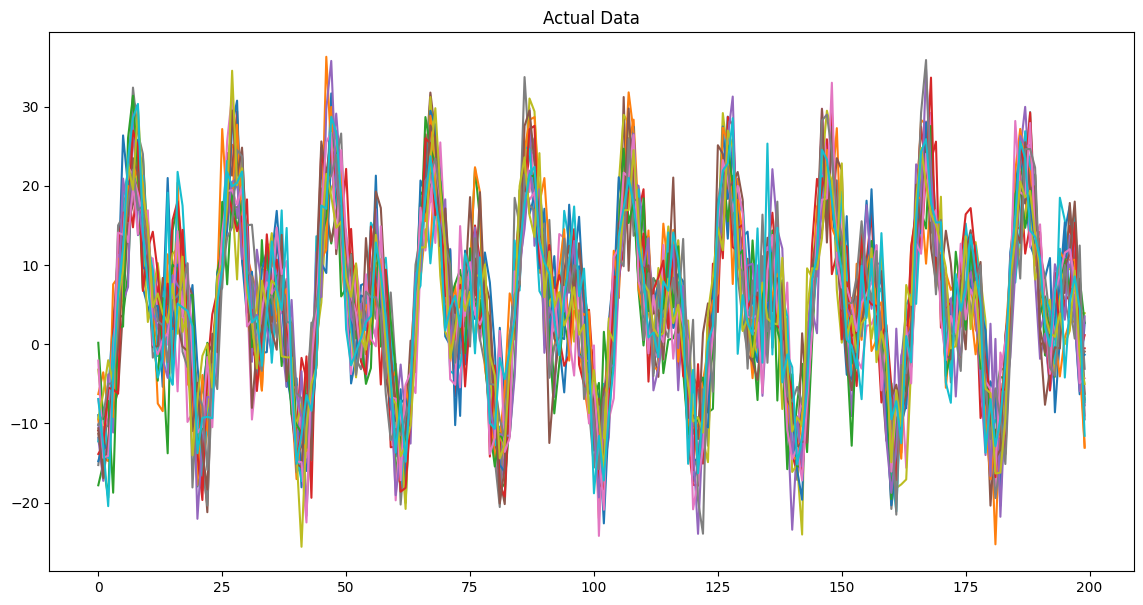

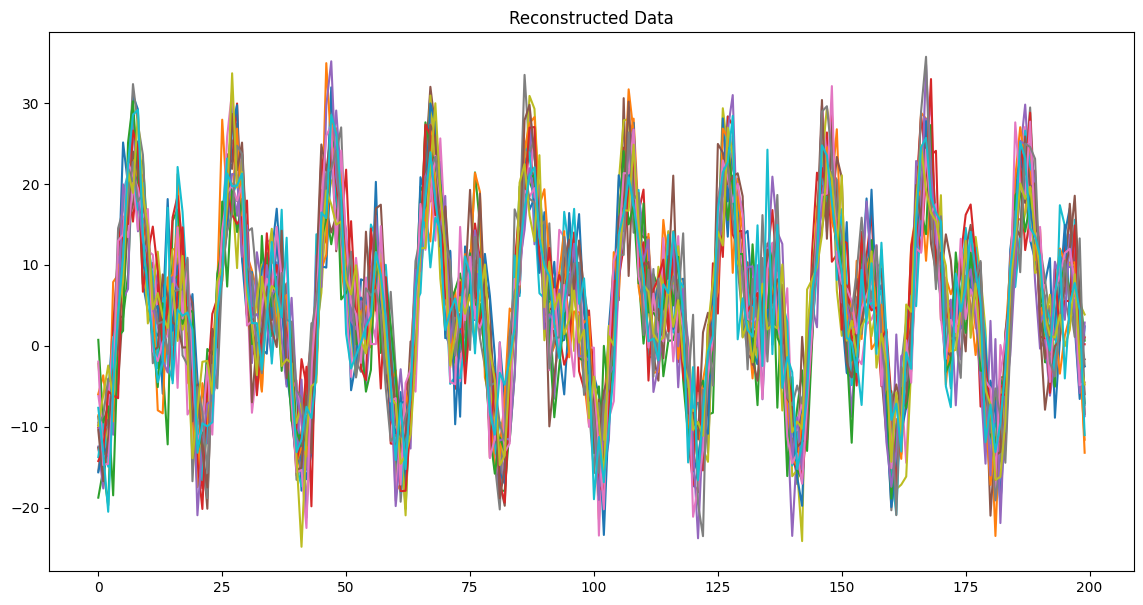

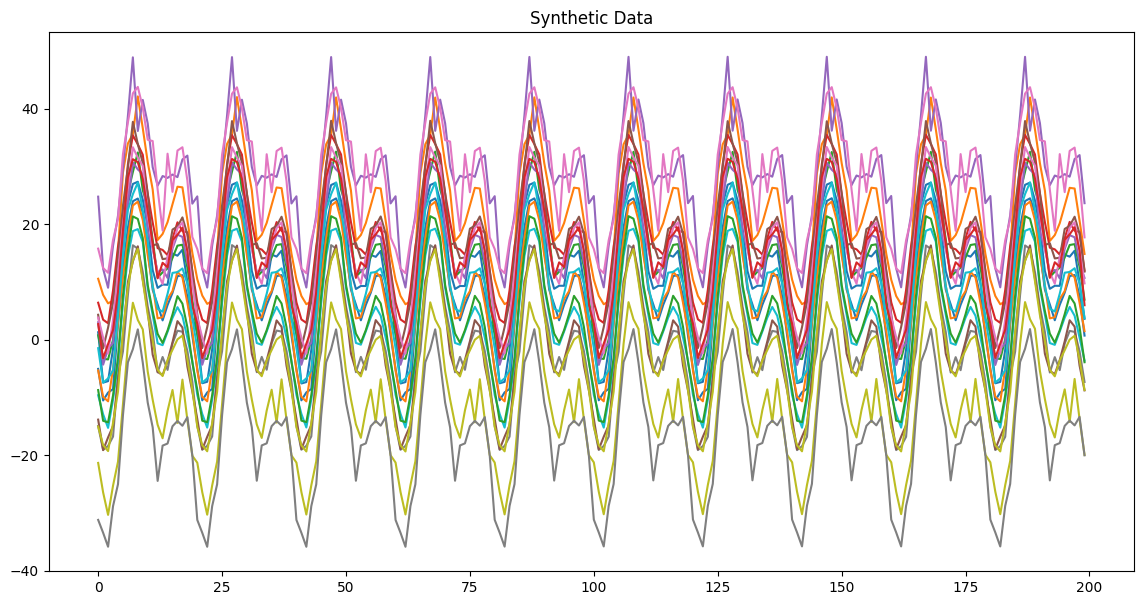

In [ ]:

# Use the plot function to visualize the data
plot(actual=x_test, reconstructed=x_hat, synthetic=x_sim)

In [ ]:
def plot(actual, reconstructed, synthetic):
    plt.figure(figsize=(14, 7))


    plt.title("Actual Data")
    plt.plot(actual.reshape(-1, actual.shape[-1]))
    plt.show()
    plt.figure(figsize=(14, 7))
    plt.title("Reconstructed Data")
    # Convert the EagerTensor to a NumPy array
    reconstructed = reconstructed.numpy()
    plt.plot(reconstructed.reshape(-1, reconstructed.shape[-1]))
    plt.show()
    plt.figure(figsize=(14, 7))
    plt.title("Synthetic Data")
    # Convert the EagerTensor to a NumPy array
    synthetic = synthetic.numpy()
    plt.plot(synthetic.reshape(-1, synthetic.shape[-1]))


    plt.show()


Predictive Score (MAE): 9.600997843198547
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 13.766097
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.858074
[t-SNE] KL divergence after 300 iterations: 0.240202


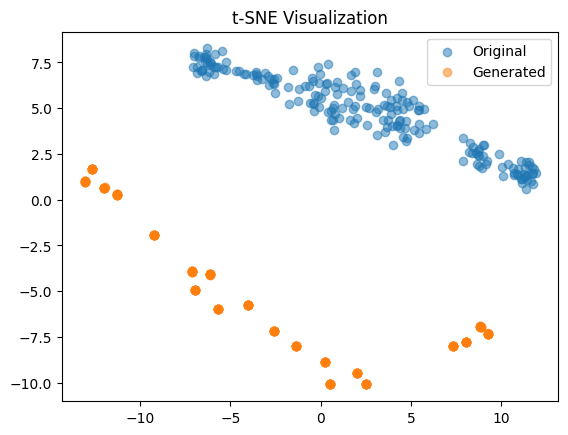

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def build_rnn_model(seq_len, dim, hidden_dim):
    """Builds an RNN model for prediction or classification."""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(seq_len, dim)))
    model.add(tf.keras.layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

def predictive_score_metrics(ori_data, generated_data, seq_len, hidden_dim=64, iterations=5000, batch_size=128):
    """Report the performance of Post-hoc RNN one-step ahead prediction."""
    no, _, dim = ori_data.shape

    # Define the RNN model
    model = build_rnn_model(seq_len - 1, dim - 1, hidden_dim)
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # Train the model on the synthetic data
    X_train = np.array([data[:-1, :] for data in generated_data])
    y_train = np.array([data[1:, -1:] for data in generated_data])
    model.fit(X_train, y_train, batch_size=batch_size, epochs=iterations, verbose=0)

    # Test the trained model on the original data
    X_test = np.array([data[:-1, :] for data in ori_data])
    y_test = np.array([data[1:, -1:] for data in ori_data])
    y_pred = model.predict(X_test)

    # Calculate MAE
    mae = np.mean([mean_absolute_error(y_test[i], y_pred[i]) for i in range(no)])
    return mae

def discriminative_score_metrics(ori_data, generated_data, seq_len, hidden_dim=64, iterations=2000, batch_size=128):
    """Use post-hoc RNN to classify original data and synthetic data."""
    no, _, dim = ori_data.shape

    # Build the RNN model
    model = build_rnn_model(seq_len, dim, hidden_dim)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Prepare data
    X_train = np.concatenate([ori_data, generated_data], axis=0)
    y_train = np.concatenate([np.ones(len(ori_data)), np.zeros(len(generated_data))], axis=0)

    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=iterations, verbose=0)

    # Test the model
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, (y_pred > 0.5).astype(int))
    discriminative_score = np.abs(accuracy - 0.5)
    return discriminative_score

def visualization(ori_data, generated_data, analysis='pca'):
    """Visualize the original and synthetic data using PCA or t-SNE."""
    no, seq_len, dim = ori_data.shape

    def flatten_data(data):
        return data.reshape(-1, data.shape[-1])

    ori_data_flat = flatten_data(ori_data)
    generated_data_flat = flatten_data(generated_data)

    if analysis == 'pca':
        pca = PCA(n_components=2)
        ori_data_pca = pca.fit_transform(ori_data_flat)
        generated_data_pca = pca.transform(generated_data_flat)

        plt.scatter(ori_data_pca[:, 0], ori_data_pca[:, 1], label='Original', alpha=0.5)
        plt.scatter(generated_data_pca[:, 0], generated_data_pca[:, 1], label='Generated', alpha=0.5)
        plt.title('PCA Visualization')
        plt.legend()
        plt.show()
    elif analysis == 'tsne':
            tsne = TSNE(n_components=2, perplexity=40, n_iter=300, verbose=1)
            combined_data = np.concatenate((ori_data_flat, generated_data_flat), axis=0)
            tsne_results = tsne.fit_transform(combined_data)

            split_index = len(ori_data_flat)
            ori_data_tsne = tsne_results[:split_index]
            generated_data_tsne = tsne_results[split_index:]

            plt.scatter(ori_data_tsne[:, 0], ori_data_tsne[:, 1], label='Original', alpha=0.5)
            plt.scatter(generated_data_tsne[:, 0], generated_data_tsne[:, 1], label='Generated', alpha=0.5)
            plt.title('t-SNE Visualization')
            plt.legend()
            plt.show()

    else:
        raise ValueError("Invalid analysis type. Choose 'pca' or 'tsne'.")

# Example usage:
# Define sequence length and other parameters
seq_len = 5  # Sequence length
hidden_dim = 64
iterations = 500
batch_size = 128

# Compute predictive score
#predictive_score = predictive_score_metrics(x_test, x_sim, seq_len, hidden_dim, iterations, batch_size)
print("Predictive Score (MAE):", predictive_score)


# Visualize data
visualization(x_test, x_sim.numpy(), analysis='tsne')  # or 'tsne'




In [ ]:
np.mean(x_test_original)

180.74656049574997